In [1]:
import matplotlib.pyplot as plt
import sys
# sys.path.append("D:\GitHub\pymrghost")
from mrfft import *
from nyquist_ghost_correction import *
import pathlib
import torch
import twixtools

import numpy as np
import sigpy as sp

# from sigpy import extract_dicom
from sigpy.mri import app, epi, sms, util

C:\Workspace\sigpy_glaser\sigpy\config.py:29: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
DLL load failed while importing cudnn: Das angegebene Modul wurde nicht gefunden.
  warnings.warn(


In [27]:
datstr = r'W:\radiologie\mrt-probanden\AG_Laun\Julius Glaser\EPI2d_diff_raw_vs_3scan_2_run\meas_MID00063_FID12654_ep2d_diff_inplane_3.dat'
outprefstr = datstr.split('.dat')[0]
# make a new directory if not exist
pathlib.Path(outprefstr).mkdir(parents=True, exist_ok=True)
# %%
mapped = twixtools.map_twix(datstr)
remove_os = True
if remove_os is False:
    oversamp = 2
    kdatstr = '_os2'
else:
    oversamp = 1
    kdatstr = ''
# %% twix read
kdat_twix = mapped[1]['image']
kdat_twix.flags['regrid'] = True
kdat_twix.flags['remove_os'] = remove_os
kdat_twix.flags['zf_missing_lines'] = False
kdat_twix.flags['skip_empty_lead'] = True
kdat_twix.flags['average']['Seg'] = False

pcor_twix = mapped[1]['phasecorr']
pcor_twix.flags['regrid'] = True
pcor_twix.flags['remove_os'] = remove_os
pcor_twix.flags['skip_empty_lead']=True
pcor_twix.flags['average']['Seg'] = False

refscan_twix = mapped[1]['refscan']
refscan_twix.flags['regrid'] = True
refscan_twix.flags['remove_os'] = remove_os
refscan_twix.flags['zf_missing_lines'] = False
refscan_twix.flags['skip_empty_lead']=True
refscan_twix.flags['average']['Seg'] = True

refscanPC_twix = mapped[1]['phasecorr']
refscanPC_twix.flags['regrid'] = True
refscanPC_twix.flags['remove_os'] = remove_os
refscan_twix.flags['zf_missing_lines'] = False
refscanPC_twix.flags['skip_empty_lead']=True
refscanPC_twix.flags['average']['Seg'] = False
# refscanPC_twix.flags['average']['Rep'] = True

noise_twix = mapped[1]['noise']
noise_twix.flags['regrid'] = True
noise_twix.flags['remove_os'] = remove_os
noise_twix.flags['zf_missing_lines'] = False
noise_twix.flags['skip_empty_lead']=True
noise_twix.flags['average']['Seg'] = False
# refscanPC_twix.flags['average']['Rep'] = True



# %% get bvals and bvecs from DICOM
hdr_twix = mapped[1]['hdr']
MB = hdr_twix['Phoenix']['sSliceAcceleration']['lMultiBandFactor']
N_slice = hdr_twix['Phoenix']['sSliceArray']['lSize']
N_segments = hdr_twix['Phoenix']['sFastImaging']['lSegments']
iPat = hdr_twix['Phoenix']['sPat']['lAccelFactPE']
print('> hdr parameters:')
print('  multi-band ' + str(MB) + ', slices ' + str(N_slice) + ', segments ' + str(N_segments)+ ', iPat ' + str(iPat))


N_diff = kdat_twix.shape[-9]  # Rep
N_y = kdat_twix.shape[-3]     # Lin
N_x = kdat_twix.shape[-1]     # Col
N_coil = kdat_twix.shape[-2]  # Cha

print('> kdat shape: \t\t', kdat_twix.shape)
print('> pcor shape: \t\t', pcor_twix.shape)
print('> refscanPC shape: \t\t', refscanPC_twix.shape)
print('> refscan shape: \t\t', refscan_twix.shape)
print('> noise shape: \t\t', noise_twix.shape)

noise_whiteing = True

if noise_whiteing == False:
    print('>> apply noise whitening to kspace and ref and correction data')
    noise = noise_twix[:]
    cov = util.get_cov(noise.squeeze())

    # whiten k-space data
    kdat = kdat_twix[:]
    kdat = np.swapaxes(kdat, axis1=-1, axis2=-2)
    kdat_whiten = util.whiten(kdat.T, cov)
    kdat_whiten = kdat_whiten.T
    kdat_whiten = np.swapaxes(kdat_whiten, axis1=-1, axis2=-2)

    refs = refscan_twix[:]
    refs = np.swapaxes(refs, axis1=-1, axis2=-2)
    refs_whiten = util.whiten(refs.T, cov)
    refs_whiten = refs_whiten.T
    refs_whiten = np.swapaxes(refs_whiten, axis1=-1, axis2=-2)

    refscanPC = refscanPC_twix[:]
    refscanPC = np.swapaxes(refscanPC, axis1=-1, axis2=-2)
    refscanPC_whiten = util.whiten(refscanPC.T, cov)
    refscanPC_whiten = refscanPC_whiten.T
    refscanPC_whiten = np.swapaxes(refscanPC_whiten, axis1=-1, axis2=-2)

    pcor = pcor_twix[:]
    pcor = np.swapaxes(pcor, axis1=-1, axis2=-2)
    pcor_whiten = util.whiten(pcor.T, cov)
    pcor_whiten = pcor_whiten.T
    pcor_whiten = np.swapaxes(pcor_whiten, axis1=-1, axis2=-2)

    print('>> Done with whitening')
    print('> kdat shape: \t\t', kdat_whiten.shape)
    print('> pcor shape: \t\t', pcor_whiten.shape)
    print('> refscanPC shape: \t\t', refscanPC_whiten.shape)
    print('> refscan shape: \t\t', refs_whiten.shape)
    print('> noise shape: \t\t', noise_twix.shape)
else:
    print('No whitening!')
    pcor_whiten = pcor_twix[:]
    refscanPC_whiten = refscanPC_twix[:]
    refs_whiten = refscan_twix[:]
    kdat_whiten = kdat_twix[:]


Software version: VD/VE (!?)

Scan  0


100%|██████████| 31.0M/31.0M [00:00<00:00, 97.4MB/s]


WARNING more than one slice. Taking first one..
Scan  1


100%|██████████| 196M/196M [00:02<00:00, 93.3MB/s] 


> hdr parameters:
  multi-band 1, slices 20, segments 1, iPat 3
> kdat shape: 		 (1, 1, 1, 1, 1, 2, 1, 4, 1, 1, 1, 20, 1, 127, 16, 130)
> pcor shape: 		 (1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 20, 1, 1, 16, 130)
> refscanPC shape: 		 (1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 20, 1, 1, 16, 130)
> refscan shape: 		 (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 20, 1, 126, 16, 130)
> noise shape: 		 (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 16, 130)
No whitening!


In [28]:
kdat_whiten = kdat_whiten.squeeze()
kdat_whiten = kdat_whiten[0,...] + kdat_whiten[1,...]
kdat_whiten.shape

(4, 20, 127, 16, 130)

In [15]:
kdat_whiten = np.transpose(kdat_whiten, (-1, -3, -2, -4, -5))

In [16]:
ksp = kdat_whiten

In [ ]:
refs_whiten = refs_whiten.squeeze()
refs_whiten = np.transpose(refs_whiten, (-1, -3, -2, -4))
ksp = refs_whiten

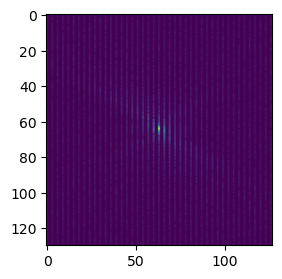

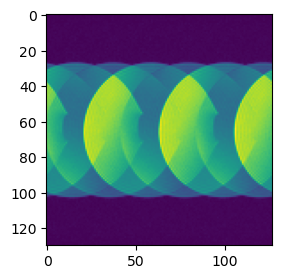

In [17]:
plt.figure(figsize=(3,3))
plt.imshow(np.abs(ksp[...,0,18,0])**0.5)
plt.show()
plt.figure(figsize=(3,3))
plt.imshow(sos(ifft2c(ksp[...,18,0],(0,1)),2))
plt.show()

In [18]:
ksp = ksp[...,0]
ksp.shape

(130, 127, 16, 20)

In [20]:
ksp = ksp[:,0:126,:,:]
ksp.shape

(130, 126, 16, 20)

In [21]:
epi_kxkyzc_raw = np.moveaxis(ksp, 2, 3) # kx, ky, slice, coil
epi_kxkyzc_lpcCor, phasepara = oneDimLinearCorr_entropy(epi_kxkyzc_raw, nShot=3) # single-shot EPI

100%|██████████| 20/20 [00:23<00:00,  1.18s/it]


In [22]:
epi_kxkyzc_lpcCor.shape

(130, 126, 20, 16)

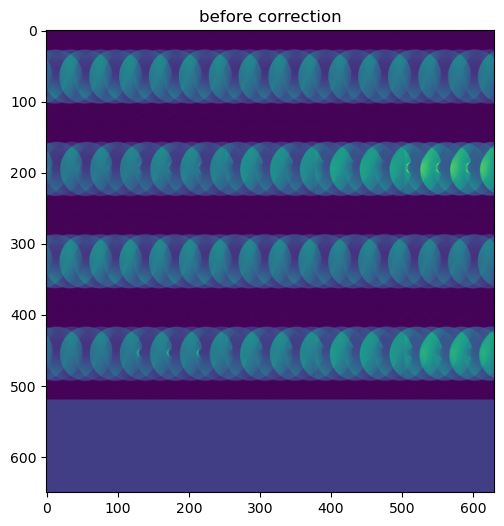

In [25]:
from skimage.util import montage
plt.figure(figsize=(6,6))
plt.imshow(montage(sos(ifft2c(np.moveaxis(epi_kxkyzc_raw,2,0),(1,2)),-1)))
plt.title('before correction')
plt.show()


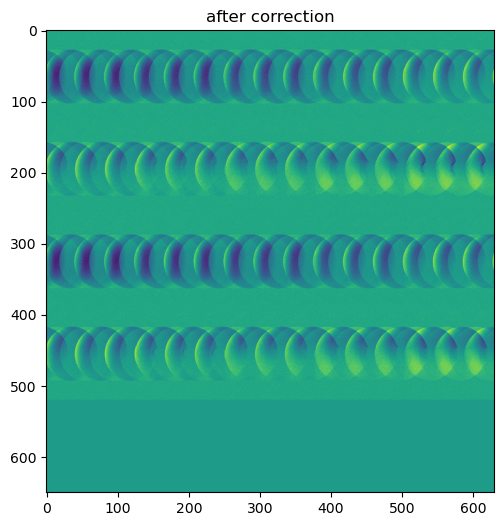

In [26]:
plt.figure(figsize=(6,6))
plt.imshow(montage(sos(ifft2c(np.moveaxis(epi_kxkyzc_lpcCor,2,0),(1,2))-1)))
plt.title('after correction')
plt.show()

In [29]:
epi_kxkyzc_lpcCor.shape

(130, 126, 20, 16)

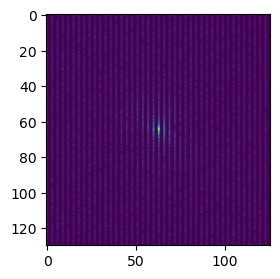

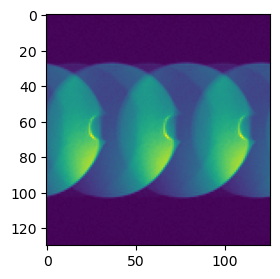

In [31]:
plt.figure(figsize=(3,3))
plt.imshow(np.abs(epi_kxkyzc_lpcCor[...,0,0])**0.5)
plt.show()
plt.figure(figsize=(3,3))
plt.imshow(sos(ifft2c(epi_kxkyzc_lpcCor[...,0],(0,1)),2))
plt.show()

In [12]:
epi_kxkyzc_CPC, phasepara2 = oneDimConstCorr_entropy(epi_kxkyzc_lpcCor, nShot=3) # single-shot EPI

100%|██████████| 20/20 [00:02<00:00,  7.44it/s]


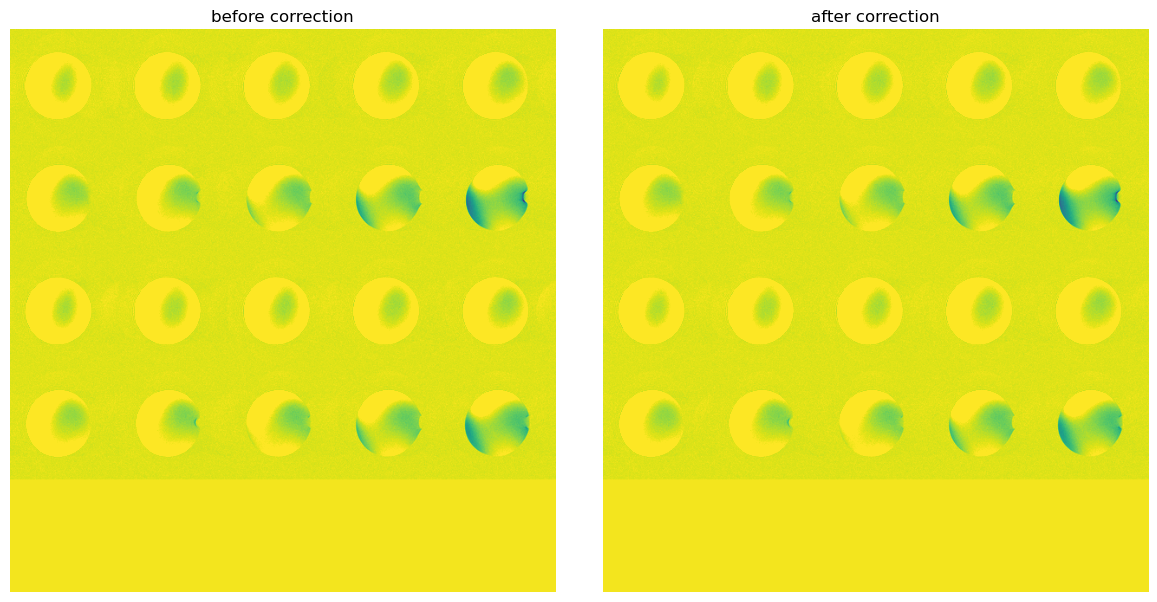

In [52]:
import matplotlib.pyplot as plt
from skimage.util import montage
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# First subplot (before correction)
axs[0].imshow(montage(sos(ifft2c(np.moveaxis(LPC_mat, 2, 0), (1, 2))-1)), vmax=4.00001)
axs[0].set_title('before correction')
axs[0].axis('off')  # Optional: hide axis ticks

# Second subplot (after correction)
axs[1].imshow(montage(sos(ifft2c(np.moveaxis(LPC1_mat, 2, 0), (1, 2))-1)), vmax=4.00001)
axs[1].set_title('after correction')
axs[1].axis('off')  # Optional: hide axis ticks

plt.tight_layout()
plt.show()


In [20]:
import scipy.io

# Load the .mat file
LPC_mat = scipy.io.loadmat(r'C:\Users\glaserjs\Downloads\PEC_GRAPPA_release\LPC.mat')
LPC_mat = LPC_mat['epi_kxkyzc_LPC']
LPC1_mat = scipy.io.loadmat(r'C:\Users\glaserjs\Downloads\PEC_GRAPPA_release\LPC1.mat')
LPC1_mat = LPC1_mat['epi_kxkyzc_LPC1']
CPC_mat = scipy.io.loadmat(r'C:\Users\glaserjs\Downloads\PEC_GRAPPA_release\CPC.mat')
CPC_mat = CPC_mat['epi_kxkyzc_CPC']


In [28]:
LPC1_mat.shape

(130, 126, 20, 16)

In [36]:
pos_echo = np.zeros_like(LPC1_mat)
neg_echo = np.zeros_like(LPC1_mat)
for i in range(3):
    pos_echo[:,i::6,...] = LPC1_mat[:,i::6,...]
    neg_echo[:,3+i::6,...] = LPC1_mat[:,3+i::6,...]

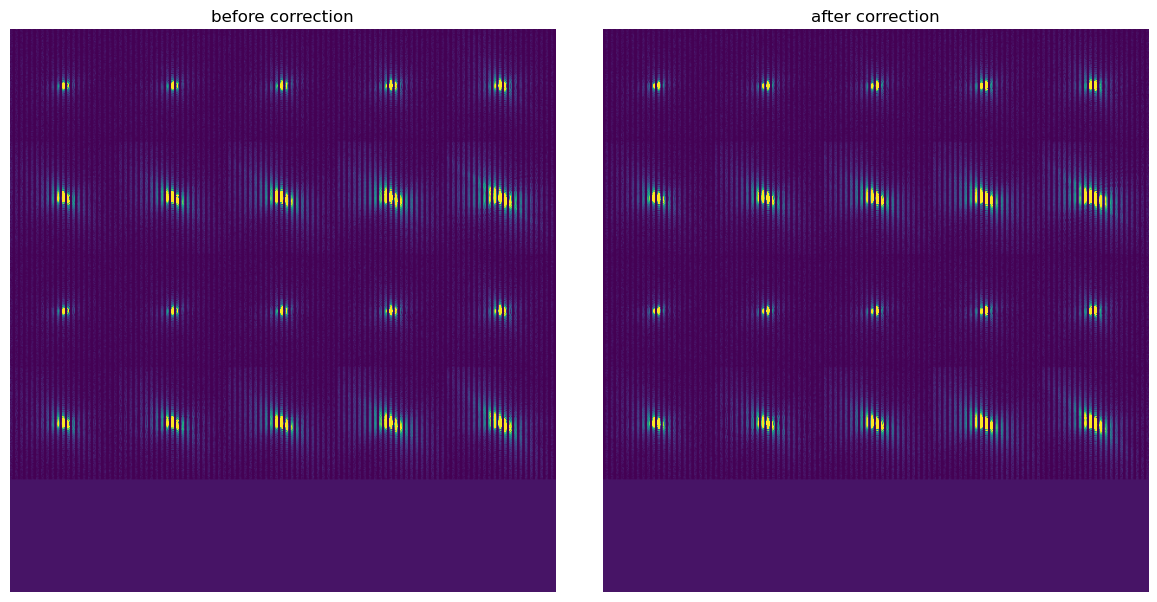

In [37]:
import matplotlib.pyplot as plt
from skimage.util import montage
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# First subplot (before correction)
axs[0].imshow(montage(abs(np.moveaxis(pos_echo, 2, 0)[..., 9])), vmax=0.0001)
axs[0].set_title('before correction')
axs[0].axis('off')  # Optional: hide axis ticks

# Second subplot (after correction)
axs[1].imshow(montage(abs(np.moveaxis(neg_echo, 2, 0)[..., 9])), vmax=0.0001)
axs[1].set_title('after correction')
axs[1].axis('off')  # Optional: hide axis ticks

plt.tight_layout()
plt.show()


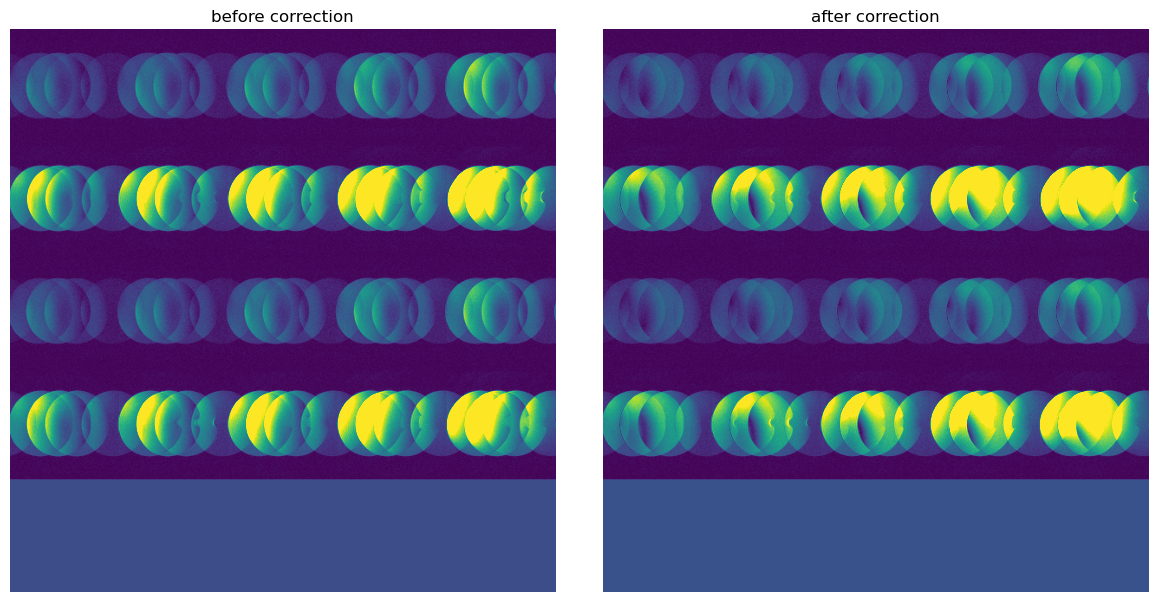

In [38]:
import matplotlib.pyplot as plt
from skimage.util import montage
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# First subplot (before correction)
axs[0].imshow(montage(abs(ifft2c(np.moveaxis(pos_echo, 2, 0), (1, 2))[..., 9])), vmax=0.0001)
axs[0].set_title('before correction')
axs[0].axis('off')  # Optional: hide axis ticks

# Second subplot (after correction)
axs[1].imshow(montage(abs(ifft2c(np.moveaxis(neg_echo, 2, 0), (1, 2))[..., 9])), vmax=0.0001)
axs[1].set_title('after correction')
axs[1].axis('off')  # Optional: hide axis ticks

plt.tight_layout()
plt.show()


In [53]:
import h5py
print('>> refs_cor shape: ',epi_kxkyzc_lpcCor.shape)

refs_cor_r = LPC1_mat.T
calib = refs_cor_r.shape[-2]#list(refs_cor_r.shape[1:])
print(calib)
print('refs_cor_r shape: ',refs_cor_r.shape)


if True:
    print('SAKE reference correction')
    refs_SAKE_zf, res, combined_save, pre_comb_save = epi.SAKE_ref_correction(refs_cor_r.T, calib, iPat=3)
    f = h5py.File(outprefstr + '/refs_SAKE_MS_skare_new.h5', 'w')
    f.create_dataset('refs', data=refs_SAKE_zf)
    f.create_dataset('single_echo_reco', data=res)
    f.create_dataset('sep_shots_refs', data=combined_save)
    f.close()

>> refs_cor shape:  (130, 126, 20, 16)
126
refs_cor_r shape:  (16, 20, 126, 130)
SAKE reference correction
>> slice number  0
(126, 126, 96)
(126, 126, 96)
20
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
>> slice number  1
(126, 126, 96)
(126, 126, 96)
20
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
>> slice number  2
(126, 126, 96)
(126, 126, 96)
20
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
>> slice number  3
(126, 126, 96)
(126, 126, 96)
20
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
>> slice number  4
(126, 126, 96)
(126, 126, 96)
20
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
>> slice number  5
(126, 126, 96)
(126, 126, 96)
20
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
>> slice number  6
(126, 126, 96)
(126, 126, 96)
20
19
19
1

In [111]:
refs_SAKE_zf_T = refs_SAKE_zf.T

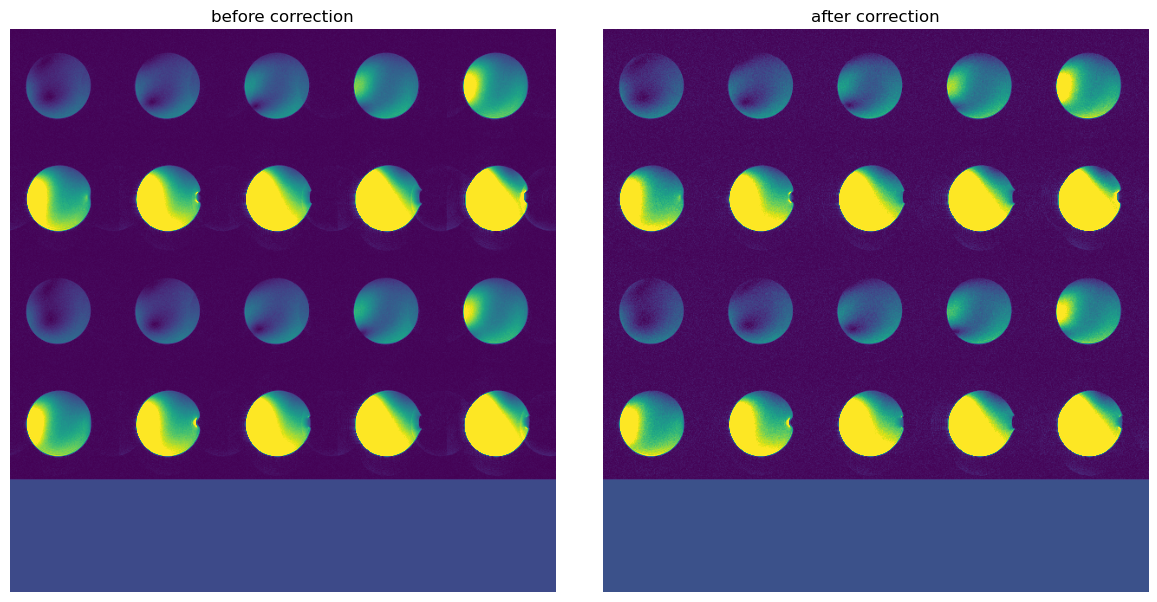

In [119]:
import matplotlib.pyplot as plt
from skimage.util import montage
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# First subplot (before correction)
axs[0].imshow(montage(abs(ifft2c(np.moveaxis(refs_SAKE_zf_T, 2, 0), (1, 2))[..., 10])), vmax=0.0001)
axs[0].set_title('before correction')
axs[0].axis('off')  # Optional: hide axis ticks

# Second subplot (after correction)
axs[1].imshow(montage(abs(ifft2c(np.moveaxis(LPC1_mat, 2, 0), (1, 2))[..., 10])), vmax=0.0001)
axs[1].set_title('after correction')
axs[1].axis('off')  # Optional: hide axis ticks

plt.tight_layout()
plt.show()


In [120]:
import scipy.io

# Load the .mat file
VCSAKE_mat = scipy.io.loadmat(r'C:\Users\glaserjs\Downloads\PEC_GRAPPA_release\SbData_sake_ksize3_Iter50.mat')


In [ ]:
VCSAKE_mat['epi_kxkyzc_sakeCor'].shape

dict_keys(['__header__', '__version__', '__globals__', 'threshold_list', 'epi_kxkyzc_sakeCor', 'epi_kxkyzc_sakeCor_fullCoils'])

In [124]:
VC_SAKE_CORR = VCSAKE_mat['epi_kxkyzc_sakeCor']

In [128]:
VC_SAKE_CORR_zf = sp.resize(VC_SAKE_CORR, oshape=LPC1_mat.shape)

In [134]:
VC_SAKE_CORR_zf.shape

(130, 126, 20, 16)

In [135]:
VC_SAKE_CORR_zf_reord = sms.reorder_slices_mb1(VC_SAKE_CORR_zf, N_slice, slice_axis=-2)

acquired slice: 000 --> geometric slice: 001
acquired slice: 001 --> geometric slice: 003
acquired slice: 002 --> geometric slice: 005
acquired slice: 003 --> geometric slice: 007
acquired slice: 004 --> geometric slice: 009
acquired slice: 005 --> geometric slice: 011
acquired slice: 006 --> geometric slice: 013
acquired slice: 007 --> geometric slice: 015
acquired slice: 008 --> geometric slice: 017
acquired slice: 009 --> geometric slice: 019
acquired slice: 010 --> geometric slice: 000
acquired slice: 011 --> geometric slice: 002
acquired slice: 012 --> geometric slice: 004
acquired slice: 013 --> geometric slice: 006
acquired slice: 014 --> geometric slice: 008
acquired slice: 015 --> geometric slice: 010
acquired slice: 016 --> geometric slice: 012
acquired slice: 017 --> geometric slice: 014
acquired slice: 018 --> geometric slice: 016
acquired slice: 019 --> geometric slice: 018


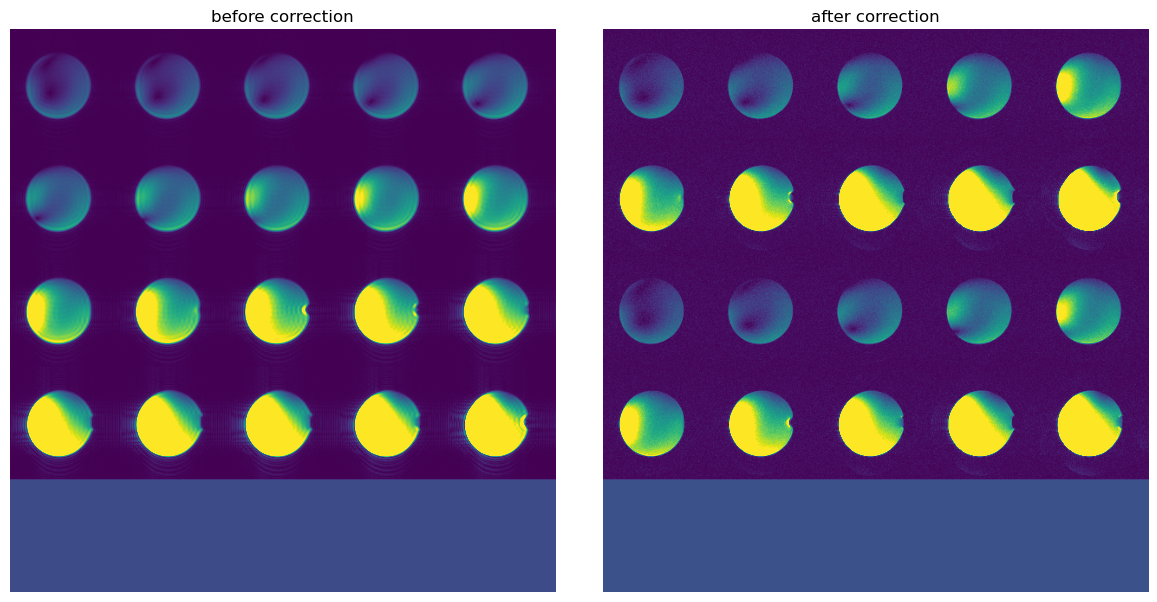

In [ ]:
import matplotlib.pyplot as plt
from skimage.util import montage
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# First subplot (before correction)
axs[0].imshow(montage(abs(ifft2c(np.moveaxis(VC_SAKE_CORR_zf_reord, 2, 0), (1, 2))[..., 10])), vmax=0.0001)
axs[0].set_title('before correction')
axs[0].axis('off')  # Optional: hide axis ticks

# Second subplot (after correction)
axs[1].imshow(montage(abs(ifft2c(np.moveaxis(LPC1_mat, 2, 0), (1, 2))[..., 10])), vmax=0.0001)
axs[1].set_title('after correction')
axs[1].axis('off')  # Optional: hide axis ticks

plt.tight_layout()
plt.show()


In [13]:
epi_kxkyzc_raw = np.moveaxis(ksp, 2, 3) # kx, ky, slice, coil
epi_kxkyzc_lpcCor2 = oneDimLinearCorr_parameter(epi_kxkyzc_raw, 1, phasepara) # parameter based correction

In [14]:
np.allclose(np.abs(epi_kxkyzc_lpcCor2),np.abs(epi_kxkyzc_lpcCor))

False

In [12]:
from partial_fourier_recon import pf_recon_pocs_ms2d

In [13]:
kspFull_kxkyzc, kspZpad_kxkyzc = pf_recon_pocs_ms2d(epi_kxkyzc_lpcCor2, iter=10, pf_axis=1, slice_coil_axes=(-2, -1))

auto detect peak at 64; full Nx is 128


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.20it/s]


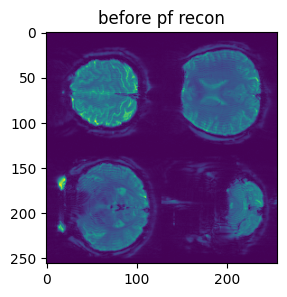

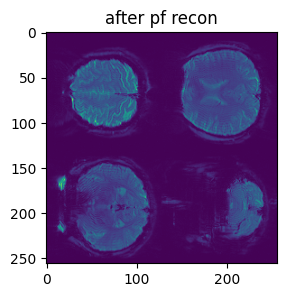

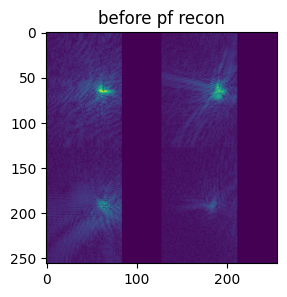

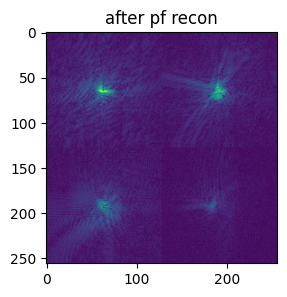

In [14]:
from skimage.util import montage
plt.figure(figsize=(3,3))
plt.imshow(montage(sos(ifft2c(np.moveaxis(kspZpad_kxkyzc[...,10:-10:8,:],-2,0),(1,2)),-1)))
plt.title('before pf recon')
plt.show()

plt.figure(figsize=(3,3))
plt.imshow(montage(sos(ifft2c(np.moveaxis(kspFull_kxkyzc[...,10:-10:8,:],-2,0),(1,2)),-1)))
plt.title('after pf recon')
plt.show()

plt.figure(figsize=(3,3))
plt.imshow(montage(np.sqrt(np.abs(np.moveaxis(kspZpad_kxkyzc[:,:,10:-10:8,0],-1,0)))))
plt.title('before pf recon')
plt.show()
plt.figure(figsize=(3,3))
plt.imshow(montage(np.sqrt(np.abs(np.moveaxis(kspFull_kxkyzc[:,:,10:-10:8,0],-1,0)))))
plt.title('after pf recon')
plt.show()